# **Dependancies**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/btc_data')

In [3]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.3 MB/s eta 0:00:00


# **Loading Data**

In [4]:
import pandas as pd

# Đường dẫn đến file btc_data.csv
file_path = '/content/drive/My Drive/Colab Notebooks/btc_data/BTC_Data_2014-2022.csv'

# Đọc file CSV
data = pd.read_csv(file_path)


# Hiển thị 10 dòng đầu tiên
data.head(10)


,Date,priceUSD,size,sentbyaddress,transactions,mining_profitability,sentinusd,transactionfees,median_transaction_fee,confirmationtime,marketcap,transactionvalue,mediantransactionvalue,tweets,google_trends,fee_to_reward,activeaddresses,top100cap
0,2014/04/09,447.110,243742.0,122401,64992,38.678,239212041.0,0.1390,0.0447,8.944,5587996110,4115.0,100.420,8193,11.193,0.502,179274,19.211
1,2014/04/10,407.703,254334.0,124298,67872,31.917,310367120.0,0.0864,0.0408,9.290,5020359905,4876.0,120.946,15039,13.854,0.371,182996,19.166
2,2014/04/11,403.328,223656.0,117926,65563,36.814,292756343.0,0.0858,0.0403,8.521,5068919648,4819.0,108.481,14907,12.997,0.330,169622,19.141
3,2014/04/12,425.310,169964.0,87828,47579,34.498,157264741.0,0.0811,0.0425,8.944,5329088351,3574.0,84.408,7582,9.229,0.226,132283,19.145
4,2014/04/13,415.876,162260.0,94828,50981,34.141,154756367.0,0.0840,0.0416,7.701,5150414718,3332.0,69.681,10674,10.385,0.221,172708,19.131
5,2014/04/14,445.898,216048.0,127969,70026,37.973,253143718.0,0.0977,0.0446,7.461,5628122040,3990.0,115.249,13266,10.754,0.318,183291,19.146
6,2014/04/15,487.666,241539.0,123107,72627,38.650,293892234.0,0.1110,0.0488,7.912,6170470953,4479.0,123.089,14835,11.053,0.362,199054,19.124
7,2014/04/16,517.354,270984.0,114312,68435,40.201,389249585.0,0.1080,0.0517,9.057,6496569317,6046.0,129.799,15790,12.189,0.359,185075,19.146
8,2014/04/17,505.461,223631.0,102596,65021,40.706,385378002.0,0.1170,0.0505,8.521,6281237538,6384.0,102.416,15215,11.471,0.355,157751,19.092
9,2014/04/18,485.296,205478.0,100633,56836,35.818,360602878.0,0.1040,0.0485,9.000,5972292967,6461.0,107.713,14028,9.946,0.304,149452,19.054


# **Model Architecture + Training**

In [6]:
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import ModelCheckpoint
from itertools import product
from keras_tuner import HyperModel, RandomSearch

# Chuẩn bị dữ liệu

data['Date'] = pd.to_datetime(data['Date'])
X = data.drop(columns=['priceUSD', 'Date'])
y = data['priceUSD']

# Chia dữ liệu thành tập huấn luyện và kiểm tra
split_index = int(len(X) * 0.9)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

In [8]:

# Tối ưu hóa tham số cho SARIMAX
def optimize_sarimax(y_train, X_train):
    best_aic = np.inf
    best_order = None
    best_seasonal_order = None

    # Các giá trị cho p, d, q, P, D, Q, s
    p_values = [0, 1, 2]
    d_values = [0, 1, 2]
    q_values = [0, 1, 2]
    seasonal_periods = [12]  # Ví dụ cho dữ liệu theo tháng (s = 12)

    # Tạo danh sách các giá trị kết hợp của tham số
    param_grid = list(product(p_values, d_values, q_values, p_values, d_values, q_values, seasonal_periods))

    for order in param_grid:
        try:
            sarimax_model = SARIMAX(y_train, exog=X_train, order=(order[0], order[1], order[2]),
                                    seasonal_order=(order[3], order[4], order[5], order[6]))
            result = sarimax_model.fit(disp=False)
            aic = result.aic
            if aic < best_aic:
                best_aic = aic
                best_order = (order[0], order[1], order[2])
                best_seasonal_order = (order[3], order[4], order[5], order[6])
        except:
            continue

    print(f"Best SARIMAX order: {best_order}")
    print(f"Best SARIMAX seasonal order: {best_seasonal_order}")
    return best_order, best_seasonal_order

# Tối ưu hóa SARIMAX
best_order, best_seasonal_order = optimize_sarimax(y_train_scaled, X_train)

# Huấn luyện mô hình SARIMAX với tham số tối ưu
sarimax_model = SARIMAX(y_train_scaled, exog=X_train, order=best_order, seasonal_order=best_seasonal_order)
sarimax_result = sarimax_model.fit(disp=False)

# Lưu mô hình SARIMAX
save_dir = '/content/drive/My Drive/Colab Notebooks/btc_data/hybrid_model_SARIMAX-LSTM_Tham_So'
os.makedirs(save_dir, exist_ok=True)
sarimax_model_path = os.path.join(save_dir, 'sarimax_model.pkl')
with open(sarimax_model_path, 'wb') as f:
    pickle.dump(sarimax_result, f)
print(f"SARIMAX model saved at: {sarimax_model_path}")


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

Best SARIMAX order: (0, 1, 1)
Best SARIMAX seasonal order: (0, 0, 0, 12)


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX model saved at: /content/drive/My Drive/Colab Notebooks/btc_data/hybrid_model_Tham_So/sarimax_model.pkl


In [7]:
import os
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras_tuner import HyperModel, RandomSearch

# Tải dữ liệu
#file_path = '/content/drive/My Drive/Colab Notebooks/btc_data/BTC_Data_2014-2022.csv'
#data = pd.read_csv(file_path)

# Chuẩn bị dữ liệu
X = data.drop(columns=['priceUSD', 'Date'])
y = data['priceUSD']

# Chia dữ liệu thành tập huấn luyện và kiểm tra
split_index = int(len(X) * 0.9)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Chuẩn hóa dữ liệu
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)

# Tải mô hình SARIMAX đã lưu
save_dir = '/content/drive/My Drive/Colab Notebooks/btc_data/hybrid_model_SARIMAX-LSTM_Tham_So'
sarimax_model_path = os.path.join(save_dir, 'sarimax_model.pkl')
with open(sarimax_model_path, 'rb') as f:
    sarimax_result = pickle.load(f)

# Dự báo từ SARIMAX
sarimax_pred_train_scaled = sarimax_result.fittedvalues
sarimax_pred_test_scaled = sarimax_result.predict(
    start=len(y_train_scaled),
    end=len(y_train_scaled) + len(y_test_scaled) - 1,
    exog=X_test
)

# Tính residuals
residual_train = y_train_scaled - sarimax_pred_train_scaled.values.reshape(-1, 1)
residual_test = y_test_scaled - sarimax_pred_test_scaled.values.reshape(-1, 1)


# Xây dựng lớp HyperModel cho LSTM
class LSTMHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32),
                       activation='relu', return_sequences=True, input_shape=(1, 1)))
        model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32)))
        model.add(Dense(1))

        model.compile(optimizer='adam', loss='mse')
        return model

# Khởi tạo và thực hiện tìm kiếm tham số
lstm_hypermodel = LSTMHyperModel()

tuner = RandomSearch(
    lstm_hypermodel,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='my_dir',
    project_name='lstm_optimization'
)

# Huấn luyện mô hình LSTM
residual_train_reshaped = residual_train.reshape(residual_train.shape[0], 1, 1)
residual_test_reshaped = residual_test.reshape(residual_test.shape[0], 1, 1)

tuner.search(residual_train_reshaped, residual_train, epochs=2000, batch_size=32,
             validation_data=(residual_test_reshaped, residual_test))

# Lấy model tốt nhất từ tuner
best_lstm_model = tuner.get_best_models(num_models=1)[0]

# Dự báo từ mô hình LSTM
lstm_pred_train = best_lstm_model.predict(residual_train_reshaped)
lstm_pred_test = best_lstm_model.predict(residual_test_reshaped)

# Kết hợp dự báo từ SARIMAX và LSTM
combined_pred_train = sarimax_pred_train_scaled.values.reshape(-1, 1) + lstm_pred_train
combined_pred_test = sarimax_pred_test_scaled.values.reshape(-1, 1) + lstm_pred_test

# Phục hồi giá trị gốc từ scaled
y_train_original = scaler.inverse_transform(y_train_scaled)
y_test_original = scaler.inverse_transform(y_test_scaled)
combined_pred_train_original = scaler.inverse_transform(combined_pred_train)
combined_pred_test_original = scaler.inverse_transform(combined_pred_test)

# Đánh giá mô hình
test_mae = mean_absolute_error(y_test_original, combined_pred_test_original)
test_rmse = np.sqrt(mean_squared_error(y_test_original, combined_pred_test_original))
test_r2 = r2_score(y_test_original, combined_pred_test_original)
test_mse = mean_squared_error(y_test_original, combined_pred_test_original)
test_mape = np.mean(np.abs((y_test_original - combined_pred_test_original) / y_test_original)) * 100

# In kết quả của dữ liệu kiểm tra
print(f'Test MAE: {test_mae}')
print(f'Test RMSE: {test_rmse}')
print(f'Test R2: {test_r2}')
print(f'Test MSE: {test_mse}')
print(f'Test MAPE: {test_mape}%')


# Lưu mô hình LSTM tốt nhất
lstm_model_path = '/content/drive/My Drive/Colab Notebooks/btc_data/hybrid_model_SARIMAX-LSTM_Tham_So/best_lstm_model_V2.keras'
best_lstm_model.save(lstm_model_path)
print(f"LSTM model saved to: {lstm_model_path}")


Trial 4 Complete [00h 27m 05s]
val_loss: 6.377002137014642e-06

Best val_loss So Far: 5.782413154520327e-06
Total elapsed time: 02h 06m 37s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Test MAE: 145.81853387597016
Test RMSE: 161.9527936689948
Test R2: 0.9997187091935513
Test MSE: 26228.707377192
Test MAPE: 0.6605645970313035%
LSTM model saved to: /content/drive/My Drive/Colab Notebooks/btc_data/hybrid_model_SARIMAX-LSTM_Tham_So/best_lstm_model_V2.keras


In [8]:
import matplotlib.pyplot as plt

# Hiển thị kết quả dự đoán
results = pd.DataFrame({
    'Actual': y_test_original.flatten(),
    'Predicted': combined_pred_test_original.flatten()
})
print(results.head(10))

# Lưu kết quả vào file CSV
results_path = os.path.join(save_dir, 'result_predictions_V2.csv')
results.to_csv(results_path, index=False)
print(f"Predictions saved to: {results_path}")

# Đồ thị
#plt.figure(figsize=(12, 6))
#plt.plot(y_test_original.flatten(), label='Actual Prices', color='blue')
#plt.plot(combined_pred_test_original.flatten(), label='Predicted Prices', color='red')
#plt.title('Actual vs Predicted Prices (Hybrid SARIMAX + LSTM)')
#plt.xlabel('Test Sample Index')
#plt.ylabel('Price (USD)')
#plt.legend()
#plt.grid()

# Để xuất đồ thị thành hình ảnh và lưu vào file nếu cần
#plt.savefig(os.path.join(save_dir, 'prediction_comparison.png'))

# Hiển thị đồ thị
#plt.show()


    Actual     Predicted
0  43854.0  43931.082891
1  43922.0  43991.453494
2  44331.0  44410.607506
3  43185.0  43242.492156
4  42333.0  42377.561604
5  42336.0  42378.389273
6  42232.0  42276.204804
7  43867.0  43945.665285
8  43998.0  44081.257654
9  42666.0  42725.506659
Predictions saved to: /content/drive/My Drive/Colab Notebooks/btc_data/hybrid_model_SARIMAX-LSTM_Tham_So/result_predictions_V2.csv


SARIMAX model loaded successfully.
LSTM model loaded successfully.


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


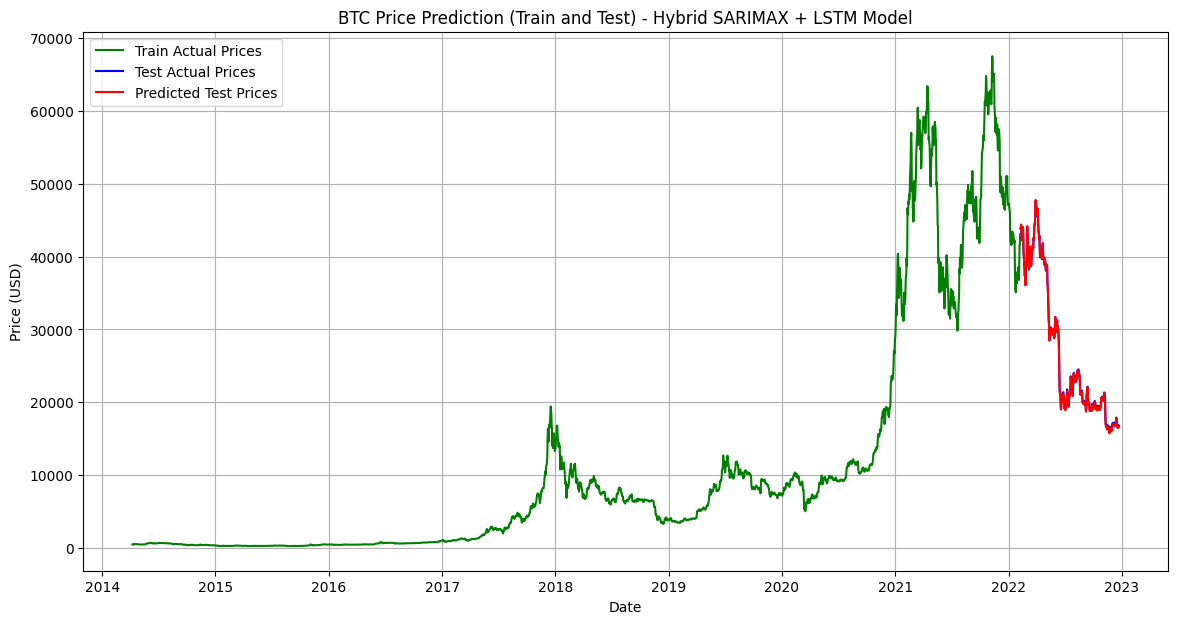

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model

# Đường dẫn tới mô hình đã lưu
sarimax_model_path = '/content/drive/My Drive/Colab Notebooks/btc_data/hybrid_model_SARIMAX-LSTM_Tham_So/sarimax_model.pkl'
lstm_model_path = '/content/drive/My Drive/Colab Notebooks/btc_data/hybrid_model_SARIMAX-LSTM_Tham_So/best_lstm_model_V2.keras'

# Tải mô hình SARIMAX đã lưu
with open(sarimax_model_path, 'rb') as f:
    sarimax_model = pickle.load(f)
print("SARIMAX model loaded successfully.")

# Tải mô hình LSTM đã lưu
lstm_model = load_model(lstm_model_path)
print("LSTM model loaded successfully.")

# Dự đoán với SARIMAX
sarimax_pred_test_scaled = sarimax_model.predict(
    start=len(y_train_scaled),
    end=len(y_train_scaled) + len(y_test_scaled) - 1,
    exog=X_test
)

# Tính residuals
residual_test_scaled = y_test_scaled - sarimax_pred_test_scaled.values.reshape(-1, 1)

# Reshape residuals cho LSTM
residual_test_reshaped = residual_test_scaled.reshape(residual_test_scaled.shape[0], 1, 1)

# Dự đoán residuals với LSTM
lstm_pred_test = lstm_model.predict(residual_test_reshaped)

# Kết hợp dự đoán từ SARIMAX và LSTM
combined_pred_test_scaled = sarimax_pred_test_scaled.values.reshape(-1, 1) + lstm_pred_test

# Chuyển ngược scale dữ liệu dự đoán và thực tế
combined_pred_test_original = scaler.inverse_transform(combined_pred_test_scaled)
y_test_original = scaler.inverse_transform(y_test_scaled.reshape(-1, 1))
y_train_original = scaler.inverse_transform(y_train_scaled.reshape(-1, 1))

# Đảm bảo cột 'Date' là kiểu datetime
data['Date'] = pd.to_datetime(data['Date'])

# Đồ thị toàn bộ dữ liệu
plt.figure(figsize=(14, 7))

# Plot dữ liệu train
plt.plot(data.iloc[:split_index]['Date'], y_train_original.flatten(), label='Train Actual Prices', color='green')

# Plot dữ liệu test
plt.plot(data.iloc[split_index:]['Date'], y_test_original.flatten(), label='Test Actual Prices', color='blue')

# Plot dự đoán tập test
plt.plot(data.iloc[split_index:]['Date'], combined_pred_test_original.flatten(), label='Predicted Test Prices', color='red')

# Thông tin đồ thị
plt.title('BTC Price Prediction (Train and Test) - Hybrid SARIMAX + LSTM Model')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()

# Tạo DataFrame kết quả
results = pd.DataFrame({
    'Date': data.iloc[split_index:]['Date'],
    'Actual_Test': y_test_original.flatten(),
    'Predicted_Test': combined_pred_test_original.flatten()
})

# Để xuất đồ thị thành hình ảnh và lưu vào file
#plt.savefig(os.path.join(save_dir, 'prediction_train_test_V2.png'))


# Lưu vào file CSV
#results_path = '/content/drive/My Drive/Colab Notebooks/btc_data/hybrid_model_SARIMAX-LSTM_Tham_So/result_train_predictions_test.csv'
#results.to_csv(results_path, index=False)
#print(f"Predictions saved to: {results_path}")


SARIMAX model loaded successfully.
LSTM model loaded successfully.


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


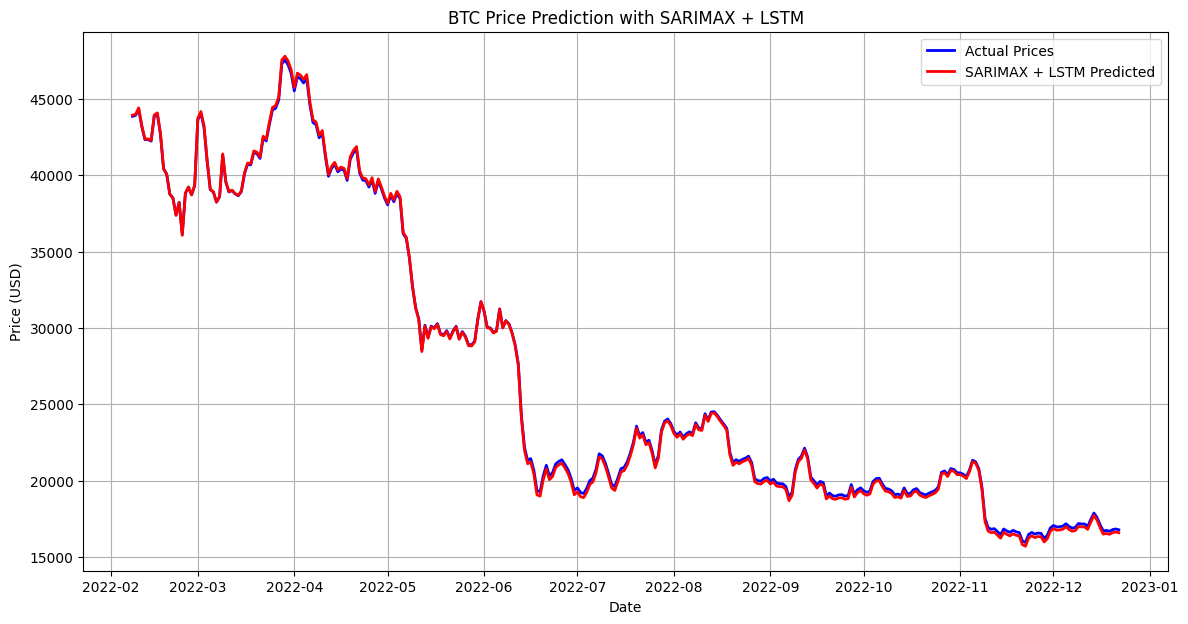

In [12]:
import os
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model

# Đường dẫn tới mô hình tốt nhất
save_dir = '/content/drive/My Drive/Colab Notebooks/btc_data/hybrid_model_SARIMAX-LSTM_Tham_So'
sarimax_model_path = os.path.join(save_dir, 'sarimax_model.pkl')
lstm_model_path = os.path.join(save_dir, 'best_lstm_model_V2.keras')

# Tải mô hình SARIMAX
with open(sarimax_model_path, 'rb') as f:
    sarimax_result = pickle.load(f)
print("SARIMAX model loaded successfully.")

# Tải mô hình LSTM
lstm_model = load_model(lstm_model_path)
print("LSTM model loaded successfully.")

# Dự đoán SARIMAX
sarimax_pred_test_scaled = sarimax_result.predict(
    start=len(y_train_scaled),
    end=len(y_train_scaled) + len(y_test_scaled) - 1,
    exog=X_test
)

# Chuyển đổi SARIMAX dự đoán thành NumPy array nếu cần
sarimax_pred_test_scaled = np.array(sarimax_pred_test_scaled).reshape(-1, 1)

# Dự đoán residuals cho LSTM
# Chuyển residual_test từ numpy array sang định dạng đúng cho LSTM
residual_test_reshaped = residual_test.reshape(residual_test.shape[0], 1, 1)

# Dự đoán LSTM
lstm_pred_test = lstm_model.predict(residual_test_reshaped)

# Tiếp tục với các bước sau



# Kết hợp dự đoán SARIMAX + LSTM
combined_pred_test = sarimax_pred_test_scaled + lstm_pred_test

# Chuyển ngược scale dữ liệu
y_test_original = scaler.inverse_transform(y_test_scaled)
sarimax_pred_original = scaler.inverse_transform(sarimax_pred_test_scaled)
combined_pred_test_original = scaler.inverse_transform(combined_pred_test)

# Đảm bảo 'Date' là kiểu datetime
data['Date'] = pd.to_datetime(data['Date'])

# Tạo các mốc thời gian cho dữ liệu huấn luyện và kiểm tra
test_dates = data.iloc[split_index:]['Date']

# Vẽ đồ thị cho SARIMAX + LSTM
plt.figure(figsize=(14, 7))

# Dữ liệu thực tế
plt.plot(test_dates, y_test_original.flatten(), label='Actual Prices', color='blue', linestyle='-', linewidth=2)

# Dự đoán kết hợp SARIMAX + LSTM
plt.plot(test_dates, combined_pred_test_original.flatten(), label='SARIMAX + LSTM Predicted', color='red', linestyle='-', linewidth=2)

# Thông tin đồ thị
plt.title('BTC Price Prediction with SARIMAX + LSTM')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()

# Tạo DataFrame kết quả
results = pd.DataFrame({
    'Date': test_dates,
    'Actual_Test': y_test_original.flatten(),
    'Predicted_Test': combined_pred_test_original.flatten()
})

# Để xuất đồ thị thành hình ảnh và lưu vào file
#plt.savefig(os.path.join(save_dir, 'prediction_year_V2.png'))

# Lưu vào file CSV
#results_path = '/content/drive/My Drive/Colab Notebooks/btc_data/hybrid_model_SARIMAX-LSTM_Tham_So/result.csv'
#results.to_csv(results_path, index=False)
#print(f"Predictions saved to: {results_path}")
